# Lab. TRIL - Carbon Capture and Storage

Engenharia Computacional para a Emissão Zero no Setor de Óleo e Gás

## Introdução 

Esse é um programa que realiza um processo de leitura, processamento e análise de um conjunto de dados de um reservatório, para encontrar classes de injetividade apresentadas com análise de gráfico.

Esse projeto é desenvolvido por:<br>
* Yhasmim de Souza Tigre - Aluna de Iniciação Científica - UFPB
* Prof. Dr. Gustavo C. Oliveira - Professor Orientador - UFPB


### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import pickle
from numba import jit 
import matplotlib.pyplot as plt
#%matplotlib inline 
#from matplotlib.pyplot import plotpip 

In [2]:
import warnings

#Serve para ignorar os 'red warnings' que algumas bibliotecas apontam porque tem novas versoes de implementacao
warnings.filterwarnings('ignore') 

## 1 - Preparação de Files 

Essas funções devem receber arquivos csv (em uma formatação pré-estabelecida) que serem lidos, checados e iniciados.<br>
Os arquivos precisam:
* ter colunas nomeadas 
* não ter valores NAN
* ter colunas na ordem correta (RQI, pressao, pressao_inversa, distancia, permeabilidade e porosidade)
* ter colunas com valores numéricos

In [3]:
'''função de leitura do arquivo csv para df'''

def read_df(df):

    df = pd.read_csv(df)
    if any(df.isna()):
        print("df com valores NAN")
        
        df = df.fillna(0)
        print("df corrigido, não mais possui valores NAN")
    
    return df

In [4]:
'''função de checagem de keys em dataframe '''

def checking(df):
    
    df = read_df(df)

    lista_primarias = ['RQI','pressao','pressao_inversa','distancia','permeabilidade','porosidade']
    lista_Js = ['J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8']  
    
    #encontrando keys estrangeiras no df
    for i in df.keys():         
        if lista_primarias.count(i) == 0: 
            print(f'variavel estrangeira "{i}" incluída no Dataframe. Não identificada na lista de variaveis primarias. \n')                 
        if lista_Js.count(i) == 0:
            print(f'variavel estrangeira "{i}" incluída no Dataframe. Não identificada na lista de variaveis secundarias Js. \n')

    #encontrando keys faltantes no df
    for i in lista_primarias:  
        if list(df.keys()).count(i) == 0:
            print(f'variavel primaria "{i}" NÃO incluída no Dataframe. Não identificada na lista de variaveis primarias. \n')
    for i in lista_Js:  
        if list(df.keys()).count(i) == 0:
            print(f'variavel secundária "{i}" NÃO incluída no Dataframe. Não identificada na lista de variaveis secundária Js. \n')
        
    return df

## 2 - Calculo dos J's

Aqui criamos funções qualificadoras, que utilizam os atributos do df para categorizar J's.

In [5]:
'''função de normalização dos dados'''

def normalization(df, J, norm=False):

    df = read_df(df)
    # df = checking(df)
    
    #atribuição        
    for j in J: 
              
        if j == 'J1':
            J1 = df['RQI']
            df['J1'] = J1
            normalize_(df, j, norm)            
                    
        if j == 'J2':
            J2 = df['RQI']*df['pressao']
            df['J2'] = J2
            normalize_(df, j, norm)

        if j == 'J3':
            J3 = df['RQI']*df['pressao_inversa']
            df['J3'] = J3
            normalize_(df, j, norm)                                                                                         
                            
        if j == 'J4':
            #para evitar resultados infinitos
            aux = np.log(df['distancia']) #calc do log(0 ind, 1 inf)
            #mascara
            aux[np.isinf(aux)] = 0 
            aux[np.isnan(aux)] = 0
            aux[aux < 0] = 0

            J4 = df['RQI'] * df['pressao'] * aux      
            df['J4'] = J4
            normalize_(df, j, norm) 

        if j == 'J5':

            aux = np.log(df['distancia'])
            aux[np.isinf(aux)] = 0 
            aux[np.isnan(aux)] = 0
            aux[aux < 0] = 0

            J5 = df['RQI'] * df['pressao_inversa'] * aux
            df['J5'] = J5
            normalize_(df, j, norm)
        
        if j == 'J6':

            aux = np.log(df['distancia'])
            aux[np.isinf(aux)] = 0 
            aux[np.isnan(aux)] = 0
            aux[aux < 0] = 0

            J6 = df['permeabilidade'] * df['porosidade'] * aux
            df['J6'] = J6
            normalize_(df, j, norm)  

    return df

def normalize_(df, col, norm):
    if norm == True:   
        df[f'{col}_normalizado'] = (df[col] - min(df[col])) / (max(df[col]) - min(df[col]))

## 3- Processamento Binning <br> (Bayesian Blocks ou KDE)
<br/>

A classe binning é responsável por processar os dados em KDE ou Bayesian Blocks 

#@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit

In [6]:
"""Processamento de dados em binning"""
class binning():

        #método construtor
        def __init__(self) -> None:
            pass
        
        #@jit(nopython=True)
        def proc_binning(df, J, binning): 

            if binning == 'kde':
                
                '''Bibliotecas'''
                import numpy as np
                from numpy import array, linspace
                from sklearn.neighbors import KernelDensity
                from scipy.misc import electrocardiogram
                from scipy.signal import argrelmin, find_peaks
                from sklearn.model_selection import GridSearchCV, LeaveOneOut
                import scipy.integrate as integrate                        
                import matplotlib.pyplot as plt
                import seaborn as sns

                '''Recebendo df'''
                #para testes com valores simplificados
                df = read_df(df)

                #para valores ja normalizados
                #df = checking(df)

                #para valores que passarão por normalização
                #df = normalization (df, J, norm=True)

                #pegando um valor menor para rodar o codigo
                df = df.sample(1500)

                '''Método de bandwith para kde'''
                
                ideal_band = 0
                #JN = {'J1_normalizado', 'J2_normalizado', 'J3_normalizado', 'J4_normalizado', 'J5_normalizado', 'J6_normalizado'}
                JN =  {'J1'}
                
                for coluna in JN:                   
                    X = df[f'{coluna}'].values[::].reshape(-1, 1)
                
                    band = np.linspace(0.01, 0.05)
                    grid = GridSearchCV(KernelDensity(), {'bandwidth': band},cv=LeaveOneOut())
                    grid.fit(X[:,None].reshape(-1, 1)) 
                    ideal_band = grid.best_params_
                    #print(ideal_band)  
                    #BANDWIDTH ORIGINAL: 0.01      
                   
                '''Calculo kde'''
                resultados_kde = {}

                for coluna in JN:                    
                    
                    # faz o reshape para encaixar os dados em uma dimensão apropriada para o calculo 
                    X = df[f'{coluna}'].values[::].reshape(-1, 1)

                    #f, a  = plt.subplots()                    
                    #h = sns.histplot(X, kde = True, element="bars", kde_kws={'bw_method':'silverman', 'bw_adjust':0.1}, ax = a, stat='probability', color= 'white', edgecolor='white', facecolor='white')       
                        
                    # calculo da densidade de probabilidade
                    kde = KernelDensity(kernel='gaussian', bandwidth = ideal_band['bandwidth']).fit(X)

                    #plt.plot(kde)
                    #sns.kdeplot(X, bw_method= 0.01, ax = a, color='black', linewidth=2.5, alpha=0.5)
                    #retorna os pontos em uma distancia equidistante / os dados precisam está em 2D
                    dist = np.linspace(0, 1.0, len(df[f'{coluna}']))

                    #calcula a probabilidade logarítmica de cada amostra sob o modelo                     
                    log = kde.score_samples(dist.reshape(-1, 1))
                    log = np.exp(log)
                    # usamos exponencial para deixar log positivo
                    #essa integral retorna o valor True ou False (estava retornando valor antes das modificações em dist e log)
                    # [:, None] é usado para realizar o broadcast dos dados (operação entre arrays de dimensões diferentes))
                    integral = float(np.exp(integrate.trapz(log[:, None], dist[:, None])).all())
                    #print(integral)
                    
                    if integral <= 1.01 and integral >= 0.99:
                        print(f'A integral : {integral} é adequeada.')
                    else:
                        print(f'A integral não está no intervalo correto: {integral}')
                        raise KeyError(f'A integral precisa estar entre 0.99 e 1.01')
                                                           
                    #Calculo das Particoes
                    # calcula os picos
                    peaks = find_peaks(log, height=min(log))
                    peaks = np.array(peaks[1]['peak_heights'])
                    print(peaks)
                    #Calcula a minima relativa dos dados
                    valleys = argrelmin(log)[0]
                    print(valleys)
                    print(type(valleys))
                    
                    #Retorna os indices que classificam o array em ordem crescente
                    ord = np.argsort(np.abs(np.diff(log[valleys])))
                    #inverte a ordem do array 
                    ordValleys_J = np.flip(ord)+1 


                    #Contrução dos intervalos de classe 

                    #utiliza o intervalo de 0 a 1 para encontrar os pontos de partição usando a minima relativa
                    ov = np.concatenate((np.array([0]), ordValleys_J, np.array([1])))
                    classes = {}
                    for i in range(1, len(ov)):
                        classes[i] = (ov[i-1], ov[i]) 
                    
                    
                    plt.figure(figsize=(20, 12))
                    plt.plot(dist, log, color='black', linewidth=2.5, alpha=0.5)  
                    a_peaks = find_peaks(log, height=min(log))
                    plt.plot(peaks, log[a_peaks[0]], "o")   
                    plt.plot(valleys[0], log[valleys[1]], "o")

                    #retorno de funcão KDE com dicionario
                    resultados_kde[coluna] = {}
                    
                    resultados_kde[coluna]['dist'] = dist
                    resultados_kde[coluna]['log'] = log
                    resultados_kde[coluna]['peaks'] = peaks
                    resultados_kde[coluna]['valleys'] = valleys
                    resultados_kde[coluna]['ordValleys_J'] = ordValleys_J
                    #resultados_kde[coluna]['classes'] = classes

                return resultados_kde   
                
            
            #Calculo Bayesian Blocks

            if binning == 'bb':
                from astropy.stats import bayesian_blocks

                
                resultados_bb = {}

                for coluna in df.columns:
                    if coluna in df.columns[12::]:
                        serie = df.query(f"{coluna} > 0")[coluna]
                        resultados_bb[coluna] = [serie, bayesian_blocks(serie)]

                return resultados_bb
            

In [7]:
'''Adição do padding '''

def padding(df, J):

    df = binning.proc_binning(df, J, binning='kde')

    padDF = np.pad(df, (0.01, 0.01)) #para a melhor localização de pontos divisores de classe
    return padDF    

## 4 - Pickle

In [8]:
def pickle (df, fileout):
    import pickle as pkl 

## 5 - Análise dos Gráficos

### Graficos dos Binnings

In [9]:
'''Classe Graficos com funções KDE e BB '''
class graficos:

    #método construtor
    def __init__(self) -> None:
        pass  
     
    '''Função de plotagem do KDE ''' 
    def grafico_kde(df, J, pad = False):        

        import matplotlib.pyplot as plt
        #plt.style.use(".dados/plot/ccs.mplstyle")

        if pad == True:
            df = padding(df)

        #df deve ser aquele resultante do processamento
        #df = binning.proc_binning(proc, J, binning='kde')       

        #dist  'numpy.ndarray'
        #log   'numpy.ndarray'
        #peaks 'tuple'
        #valleys 'numpy.ndarray'
        #ordValleys_J 'numpy.ndarray'
        #classes 'dict'

        for i in df:                        
            plt.plot(df[i]['dist'], df[i]['log'])
            plt.grid(True)            

        for i in J:           
            
            plt.title(f'Vales dos Kernels | {i} normalizado')
            plt.ylabel("Valor da Densidade")
            plt.xlabel(f'Posição assumida por {i} norm')                      
            
            
            plt.plot(df[i]['valleys'], df[i]['log'][df[i]['valleys']], 'o', c='red')
            plt.plot(df[i]['valleys'][df[i]['ordValleys_J'][0:4]], df[i]['log'][df[i]['valleys'][df[i]['ordValleys_J'][0:4]]], '*', c='green')

            #plot das classes
            for j in i:
                plt.plot(df[j]['classes'])

            plt.show()
            plt.savefig(f'./dados/Analise de Js/testes/{J}.jpeg', format='jpeg')

    
                
    '''Função de plotagem do BB ''' 
    def grafico_bb(df, bins_bb, J):

        df = binning.proc_binning(df, J, binning='bb')

        import matplotlib.pyplot as plt
        #plt.style.use(".dados/plot/ccs.mplstyle")

        """
        Essa funcao tem como objetivo criar uma representação gráfica
        de uma determinada 'coluna' de um determinado DataFrame (df)
        dado o calculo de seus bins/classes baseados no Bayesian Blocks.
        Pode-se obter os Bayesian Blocks de uma determinada variável
        usando a funcao 'bayesian_blocks' do módulo astropy.stats
        """
                
        
        labels = {
            "J1_normalizado" : "RQI",
            "J2_normalizado" : "RQI * Pressao",
            "J3_normalizado" : "RQI * Pressao Inversa",
            "J4_normalizado" : "RQI * Pressao * ln(distancia)",
            "J5_normalizado" : "RQI * Pressao Inversa * ln(distancia)", 
            "J6_normalizado" : "Permeabilidade * Porosidade * ln(distancia)",
            "J7_normalizado" : "ln(Permeabilidade) * ln(Porosidade) * ln(distancia)"
        }
        
        ax = plt.figure(figsize=(20, 12))
        #modificar labels para for
        ax = plt.title(f"Histograma '{J} = {labels[J]}' utilizando blocos bayesianos", fontsize = 24)
        ax = plt.xlabel("X", fontsize = 18)
        ax = plt.ylabel("Y", fontsize = 18)
        ax = plt.hist(df, bins = bins_bb, color='g')
        ax = plt.grid(True)
        plt.savefig(f'./dados/Analise de Js/bb/{J}.jpeg', format='jpeg')
        plt.show(ax)
        

In [10]:
'''#gerando gráficos bb
resultados = {}

for coluna in variaveis_df.columns:
    if coluna in variaveis_df.columns[12::]:
        serie = variaveis_df.query(f"{coluna} > 0")[coluna]
        resultados[coluna] = [serie, bayesian_blocks(serie)]
        grafico_bb(resultados[coluna][0], resultados[coluna][1], coluna)'''

'#gerando gráficos bb\nresultados = {}\n\nfor coluna in variaveis_df.columns:\n    if coluna in variaveis_df.columns[12::]:\n        serie = variaveis_df.query(f"{coluna} > 0")[coluna]\n        resultados[coluna] = [serie, bayesian_blocks(serie)]\n        grafico_bb(resultados[coluna][0], resultados[coluna][1], coluna)'

## 6 - Main 

Aqui vamos chamar o pipeline e apresentar opções ao usuário chamando as funções

In [4]:
'''chamando arquivo csv'''
arq = pd.read_csv("./dados/Simplificados/J1_reduzido.csv")
# "./dados/variaveis2.csv"

In [5]:
'''chamando a funções de preparação'''
arq = read_df("./dados/Simplificados/J1_reduzido.csv") 
#arq = read_df("./dados/variaveis2.csv")
#arq = checking(arq)

df com valores NAN
df corrigido, não mais possui valores NAN


In [6]:
J = ['J1']
#J = ['J1', 'J2', 'J3', 'J4', 'J5', 'J6']

proc = binning.proc_binning("./dados/Simplificados/J1_reduzido.csv", J, binning='kde')
#proc = binning.proc_binning("./dados/J Costa/J Costa isolados/variaveis.csv", J, binning='kde')
#proc = binning.proc_binning(arq, J, binning='bb')

NameError: name 'binning' is not defined

In [ ]:
import seaborn as sns
def plot_test(x, a):
    
    h = sns.histplot(x, kde = True, element="bars", kde_kws={'bw_method':'silverman', 'bw_adjust':0.5}, ax = a, stat='probability')

TypeError: string indices must be integers

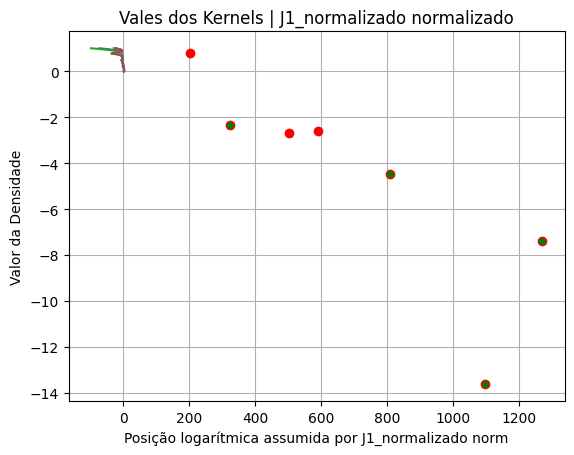

In [ ]:
#J = ['J1']
J = ['J1_normalizado', 'J2_normalizado', 'J3_normalizado', 'J4_normalizado', 'J5_normalizado', 'J6_normalizado']
pl = graficos.grafico_kde(proc, J) #debug

# Testes


In [20]:
import numpy as np
from numpy import linspace
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelmin, find_peaks
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import scipy.integrate as integrate                        
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [8]:

df = read_df("./dados/Simplificados/J1_reduzido.csv")
#df = df.sample(1500)

df com valores NAN
df corrigido, não mais possui valores NAN


In [9]:
ideal_band = 0
#JN = {'J1_normalizado', 'J2_normalizado', 'J3_normalizado', 'J4_normalizado', 'J5_normalizado', 'J6_normalizado'}
JN =  {'J1'}

#remover os zeros dos Js

for coluna in JN:                   
    X = df[f'{coluna}'].values[::].reshape(-1, 1)
    X = X[X > 0] 

    band = np.linspace(0.01, 0.05)
    grid = GridSearchCV(KernelDensity(), {'bandwidth': band},cv=LeaveOneOut())
    grid.fit(X[:,None].reshape(-1, 1)) 
    ideal_band = grid.best_params_
    #print(ideal_band)  
    #BANDWIDTH ORIGINAL: 0.01    

In [10]:
'''Calculo kde'''
resultados_kde = {}

for coluna in JN:                    
    
    # faz o reshape para encaixar os dados em uma dimensão apropriada para o calculo 
    X = df[f'{coluna}'].values[::]
    X = X[X > 0].reshape(-1, 1) 
           
    # calculo da densidade de probabilidade
    kde = KernelDensity(kernel='gaussian', bandwidth = ideal_band['bandwidth']).fit(X)

In [11]:
dist = np.linspace(0, 1.0, len(df[f'{coluna}']))

In [12]:
log = kde.score_samples(dist.reshape(-1, 1))
log = np.exp(log)                 

In [13]:
#temos que calcular a integral para verificar se  o kde está correto para ser uma distribuição de probabilidade
integral = float(np.exp(integrate.trapz(log[:, None], dist[:, None])).all())

if integral <= 1.01 and integral >= 0.99:
                    print(f'A integral : {integral} é adequeada.')
else:
    print(f'A integral não está no intervalo correto: {integral}')
    raise KeyError(f'A integral precisa estar entre 0.99 e 1.01')                                        

A integral : 1.0 é adequeada.


In [14]:
#retorna tupla com dois arrays, o primeiro com os indices dos picos e o segundo com os valores dos picos
peaks = find_peaks(log)
print(peaks)
#Calcula a minima relativa dos dados
valleys = argrelmin(log)[0]
print(valleys)
print(type(valleys))

(array([ 525,  665,  746, 1204, 1277, 1587, 1683, 2274, 2500, 2638],
      dtype=int64), {})
[ 603  734 1143 1254 1535 1649 2238 2443 2569]
<class 'numpy.ndarray'>


In [22]:
#Retorna os indices que classificam o array e calcula o valores absolutos das diferenças entre os valores dos vales e ordena em ordem crescente
"""ord = np.argsort(np.abs(np.diff(log[valleys])))
print(ord)
#inverte a ordem do array 
ordValleys_J = np.flip(ord)+1 
print(ordValleys_J)"""

[3 9 5 8 1 7 6 4 2 0]
[ 1  3  5  7  8  2  9  6 10  4]


In [15]:
#numero de classes = n-1 (numero dos dedos e espaço dentre os dedos= verdadeira classe)

#uni os valores do valleys ordenados com 0 e 1 para encontrar os pontos de partição usando a minima relativa
#ov = np.concatenate((np.array([0]), ordValleys_J, np.array([1])))

con = np.concatenate((np.array([0.0]), dist[valleys], np.array([1.0])))
#calcula a diferença entre os valores de con
comp_classe = np.diff(con)
#calcula o desvio padrão
dp = np.std(comp_classe)    
#excluindo classes com desvio padrao maior que o desvio padrão
excl = np.where(comp_classe <= dp)

#cria uma mascara para excluir os valores de con que estão fora do desvio padrão. True para manter e False para excluir
mask = np.ones(con.shape,dtype=bool)
mask[excl] = False
con = con[mask]

print(type(con))
print(con)

#como dicionario
classes = {}
for i in range(1, len(con)):
    classes[i] = (con[i-1], con[i])
print(classes)

#como lista
cl = []
for i in range(1, len(con)):
    cl.append(con[i-1])
cl.append(1.0)
print(cl)

<class 'numpy.ndarray'>
[0.         0.22075188 0.37714286 0.49593985 0.77263158 1.        ]
{1: (0.0, 0.22075187969924812), 2: (0.22075187969924812, 0.3771428571428571), 3: (0.3771428571428571, 0.4959398496240601), 4: (0.4959398496240601, 0.7726315789473683), 5: (0.7726315789473683, 1.0)}
[0.0, 0.22075187969924812, 0.3771428571428571, 0.4959398496240601, 0.7726315789473683, 1.0]


Classes iniciais antes do calculo do desvio padrão<br>
{1: (0.0, 0.1813533834586466), 2: (0.1813533834586466, 0.22075187969924812), 3: (0.22075187969924812, 0.3437593984962406), 4: (0.3437593984962406, 0.3771428571428571), 5: (0.3771428571428571, 0.4616541353383458), 6: (0.4616541353383458, 0.4959398496240601), 7: (0.4959398496240601, 0.6730827067669173), 8: (0.6730827067669173, 0.7347368421052631)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

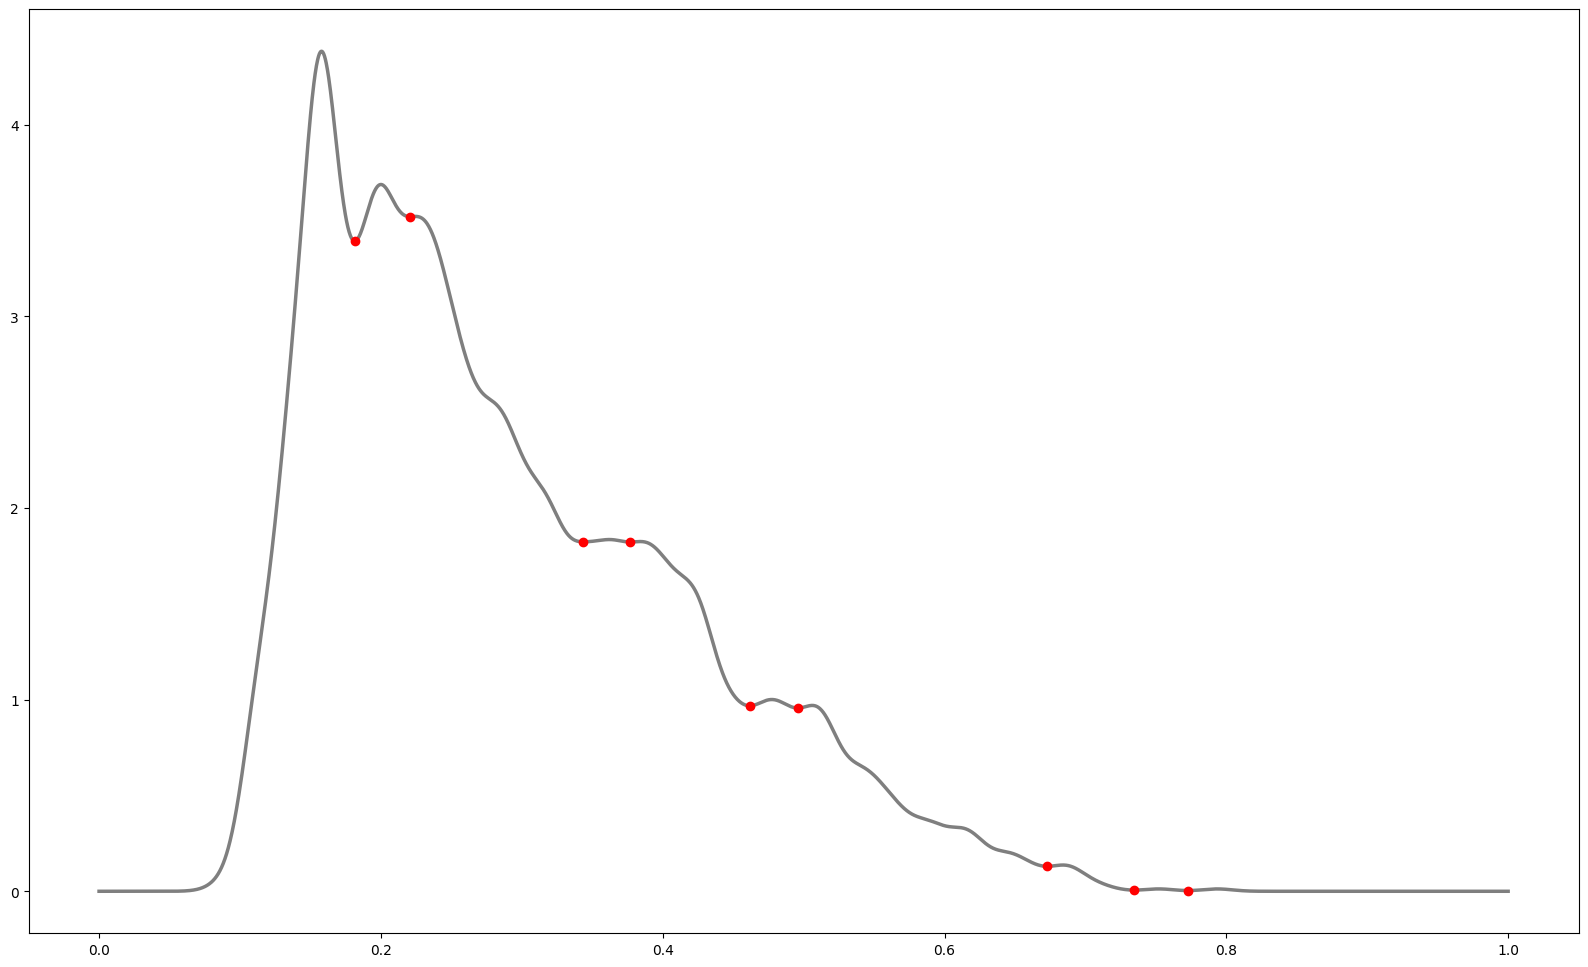

In [16]:
plt.figure(figsize=(20, 12))
plt.plot(dist, log, color='black', linewidth=2.5, alpha=0.5)  
plt.plot(dist[valleys], log[valleys], "o", color='red')
#plt.plot(dist[peaks[0]], log[peaks[0]], "^", color='blue')


plt.plot(log[cl], log, "o", color='green')

"""for i in range(1, len(con)):
    plt.plot([con[i-1], con[i]], con, color='green', linewidth=2.5, alpha=0.5)"""
#plt.scatter(dist[classes.values()], log[classes.keys()], "*", color='green')

#plt.plot(dist[classes.values()], log[classes.keys()], "*", color='green')


(1, 2, 3, 4, 5)
((0.0, 0.22075187969924812), (0.22075187969924812, 0.3771428571428571), (0.3771428571428571, 0.4959398496240601), (0.4959398496240601, 0.7726315789473683), (0.7726315789473683, 1.0))


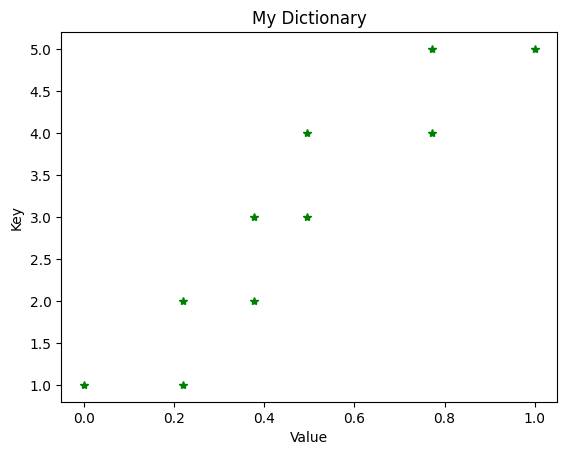

"for j in classes:\n    plt.plot(classes[j], log[classes[j]], '*', color='green')"

In [38]:
#plot das classes

myList = classes.items()
myList = sorted(myList)
x, y = zip(*myList)

print(x)
print(y)

plt.plot(y, x, '*', color='green')
plt.xlabel('Value')
plt.ylabel('Key')
plt.title('My Dictionary')
plt.show()

"""for j in classes:
    plt.plot(classes[j], log[classes[j]], '*', color='green')"""
    

In [18]:
classes = pd.DataFrame(classes)

classes

,1,2,3,4,5
0,0.000000,0.220752,0.377143,0.495940,0.772632
1,0.220752,0.377143,0.495940,0.772632,1.000000


In [79]:
for ind in range(len(classes.keys())):
    for val in range(len(classes.values())):
        plt.plot(classes[ind][val], range(len(classes[ind][val])), 'o', color='yellow')

KeyError: 0

In [37]:
classes = list(classes.items())
print(classes)
print(type(classes))

[(1, (0, 163)), (2, (163, 601)), (3, (601, 726)), (4, (726, 1133)), (5, (1133, 1252)), (6, (1252, 1534)), (7, (1534, 1648)), (8, (1648, 2013)), (9, (2013, 2235)), (10, (2235, 2441))]
<class 'list'>


In [31]:
plt.scatter(classes, log[classes], 'o', color='yellow')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [24]:
colors = list("rgbcmyk")

for dict in classes.values():
   x = dict.keys()
   y = dict.values()
   plt.scatter(x,y,color=colors.pop())

plt.legend(classes.keys())

plt.show()

AttributeError: 'tuple' object has no attribute 'keys'